# Covid 19 Visualizatuion and Prediction

- Inspired by [Coronavirus (COVID-19) Visualization & Prediction: Kaggle](https://www.kaggle.com/code/therealcyberlord/coronavirus-covid-19-visualization-prediction)
- Data provided by [Ministry of health in CZ](https://www.mzcr.cz)

In [13]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")

### Load the data

In [3]:
# Load .env file
load_dotenv()

In [4]:
confirmed_df = pd.read_csv("https://onemocneni-aktualne.mzcr.cz/api/account/{}/file/modely%2Fmodely_01_okresni_statistika.csv".format(os.getenv("APIKEY")), sep=";")
confirmed_df.head()

,datum,okres,orp,pohlavi,vek_kat,pocet_pozitivni,pocet_vyleceni,pocet_zemreli,pocet_umrti_hospitalizace,pocet_umrti_komplikovany
0,2020-03-01,CZ0421,4202,M,20-64,1.0,NaN,NaN,NaN,NaN
1,2020-03-01,CZ0100,0,M,65+,1.0,NaN,NaN,NaN,NaN
2,2020-03-01,CZ0100,0,Z,20-64,1.0,NaN,NaN,NaN,NaN
3,2020-03-03,CZ0100,0,Z,20-64,1.0,NaN,NaN,NaN,NaN
4,2020-03-03,CZ0421,4202,Z,20-64,1.0,NaN,NaN,NaN,NaN


In [5]:
hospitalized_df = pd.read_csv("https://onemocneni-aktualne.mzcr.cz/api/account/{}/file/modely%2Fmodely_05_hospitalizovani_analyza.csv".format(os.getenv("APIKEY")), sep=";")
hospitalized_df.head()

,vek_kat,pohlavi,kraj_bydliste,kraj_prvni_nemocnice,datum_priznaku,datum_odberu,datum_positivity,stav_dle_khs,zahajeni_hosp,posledni_zaznam,...,upv,upv_pocatek,dni_upv,upv_posledni,ecmo,ecmo_pocatek,dni_ecmo,ecmo_posledni,umrti,datum_umrti
0,15-19,M,CZ064,CZ010,NaN,2020-10-12,2020-10-12,NaN,2020-10-12,2020-10-23,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
1,70-74,M,CZ032,CZ032,NaN,NaN,2021-03-01,NaN,2021-03-01,2021-03-06,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
2,85-89,M,CZ020,CZ020,2020-12-07,2020-12-13,2020-12-13,NaN,2020-12-18,2020-12-21,...,0,NaN,0,NaN,0,NaN,0,NaN,1.0,2020-12-21
3,95-99,Z,CZ064,CZ064,2021-03-07,2021-03-07,2021-03-07,NaN,2021-03-07,2021-03-18,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
4,70-74,M,CZ032,CZ032,2020-04-15,2020-04-26,2020-04-26,Lehký - Lehký,2020-04-26,2020-05-23,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN


### Data preparation

Data Cleaning

In [6]:
# Replace NaN with 0
confirmed_df = confirmed_df.fillna(0)
hospitalized_df = hospitalized_df.fillna(0)

Merge confirmed dataset rows with the same date

In [7]:
confirmed_df = confirmed_df.groupby("datum").sum().reset_index()
hospitalized_df = hospitalized_df.groupby("zahajeni_hosp").sum().reset_index()

Turn the data into a time series

In [8]:
num_dates = len(confirmed_df["datum"])

total_confirmed = []
total_deaths = []
total_recovered = []
total_hospitalized = []

total_confirmed_cumulative = []
total_deaths_cumulative = []
total_recovered_cumulative = []
total_hospitalized_cumulative = []

total_active = []
mortality_rate = []
recovery_rate = []

for i in range(num_dates):
    # Daily increases
    total_confirmed.append(confirmed_df["pocet_pozitivni"][i])
    total_deaths.append(confirmed_df["pocet_zemreli"][i])
    total_recovered.append(confirmed_df["pocet_vyleceni"][i])

    # Cumulative totals
    total_confirmed_cumulative.append(sum(total_confirmed))
    total_deaths_cumulative.append(sum(total_deaths))
    total_recovered_cumulative.append(sum(total_recovered))

     # Check if the date is in the hospitalized_df
    if confirmed_df["datum"][i] in hospitalized_df["zahajeni_hosp"].values:
        # Daily increase
        total_hospitalized.append(hospitalized_df["tezky_stav"][hospitalized_df["zahajeni_hosp"] == confirmed_df["datum"][i]].values[0])
        # Cumulative total
        total_hospitalized_cumulative.append(sum(total_hospitalized))

    # Other metrics
    total_active.append(total_confirmed[i] - total_deaths[i] - total_recovered[i])
    mortality_rate.append(total_deaths[i] / total_confirmed[i])
    recovery_rate.append(total_recovered[i] / total_confirmed[i])

Calculate the moving average using pandas

In [9]:
# Calculate the moving average
window_size = 7
moving_average = lambda x: np.convolve(x, np.ones(window_size), "valid") / window_size

total_confirmed_moving_avg = moving_average(total_confirmed)
total_deaths_moving_avg = moving_average(total_deaths)
total_recovered_moving_avg = moving_average(total_recovered)
total_hospitalized_moving_avg = moving_average(total_hospitalized)

total_confirmed_cumulative_moving_avg = moving_average(total_confirmed_cumulative)
total_deaths_cumulative_moving_avg = moving_average(total_deaths_cumulative)
total_recovered_cumulative_moving_avg = moving_average(total_recovered_cumulative)
total_hospitalized_cumulative_moving_avg = moving_average(total_hospitalized_cumulative)

total_active_moving_avg = moving_average(total_active)

## Future predictions

In [10]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(total_confirmed) + days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10].flatten()

## Data Visualization

<AxesSubplot:>

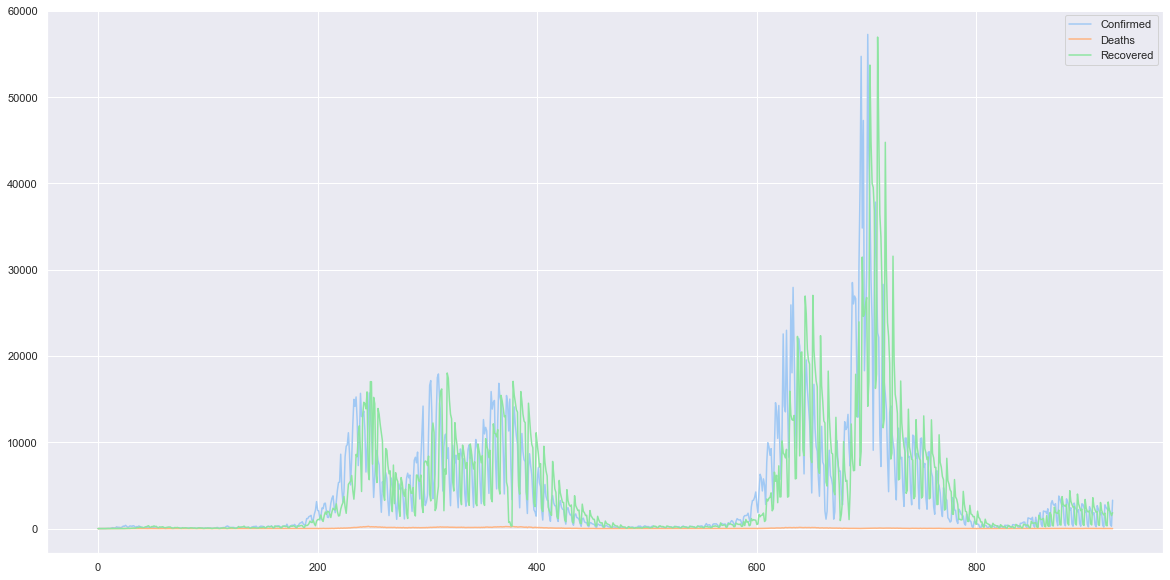

In [11]:
# Make the plot 2x bigger
plt.figure(figsize=(20, 10))

sns.lineplot(x=adjusted_dates, y=total_confirmed, label="Confirmed")
#sns.lineplot(x=range(num_dates - window_size + 1), y=total_confirmed_moving_avg, label="Confirmed (7-day moving average)")

sns.lineplot(x=range(num_dates), y=total_deaths, label="Deaths")
#sns.lineplot(x=range(num_dates - window_size + 1), y=total_deaths_moving_avg, label="Deaths (7-day moving average)")

sns.lineplot(x=range(num_dates), y=total_recovered, label="Recovered")
#sns.lineplot(x=range(num_dates - window_size + 1), y=total_recovered_moving_avg, label="Recovered (7-day moving average)")

#sns.lineplot(x=range(num_dates), y=total_hospitalized, label="Hospitalized")
#sns.lineplot(x=range(num_dates - window_size + 1), y=total_hospitalized_moving_avg, label="Hospitalized (7-day moving average)")
